May 4: Generates projection of the Arctic Ocean bathymetry using IBCAO_V3_500m_RR grid.

IBCAO_V3_500m_RR
* DBM compiled with all multibeam, dense single beam and land data added at 500 x 500 m resolution in a final step using the remove-restore method. This DBM is recommended for analyses requiring the best possible resolution where data exists. Well surveyed areas are clearly distinguished in this grid, specifically if there are nearby areas with sparse data that appear smooth.
* Resolution: 500 x 500 m grid cells
* Projection: Polar stereographic, true scale 75degN (if scale factor is applied it should be set to 0.982966757777337), latitude of origin 90degN, longitude of origin 0deg.
* Horizontal Datum: WGS84
* Vertical Datum: Mean Sea Level
* Extent (Polar stereographic coordinates): Easting -2904000 to 2904000; Northing -2904000 to 2904000
* Grid dimension: 11617 x 11617

Module source: https://github.com/nansencenter/ibcao_py

In [1]:
%matplotlib inline

In [2]:
#! /usr/bin/env python
# encoding: utf-8
#
# Author: Gaute Hope <gaute.hope@nersc.no> / 2014-02-19
#
# IBCAO interface

import  os
from    pyproj import Proj, Geod
import  scipy as sc, scipy.io
import  numpy as np
import  matplotlib.cm as cm
import  cartopy.crs as ccrs

class IBCAO:
  ibcao_grid_name = 'IBCAO_V3_500m_RR.grd'
  ibcao_grid_dir = '/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/grid'
  ibcao_grid = os.path.join(ibcao_grid_dir, ibcao_grid_name)

  VERSION = '3.0'
  REFERENCE = 'Jakobsson, M., L. A. Mayer, B. Coakley, J. A. Dowdeswell, S. Forbes, B. Fridman, H. Hodnesdal, R. Noormets, R. Pedersen, M. Rebesco, H.-W. Schenke, Y. Zarayskaya A, D. Accettella, A. Armstrong, R. M. Anderson, P. Bienhoff, A. Camerlenghi, I. Church, M. Edwards, J. V. Gardner, J. K. Hall, B. Hell, O. B. Hestvik, Y. Kristoffersen, C. Marcussen, R. Mohammad, D. Mosher, S. V. Nghiem, M. T. Pedrosa, P. G. Travaglini, and P. Weatherall, The International Bathymetric Chart of the Arctic Ocean (IBCAO) Version 3.0, Geophysical Research Letters, doi: 10.1029/2012GL052219.'

  # previously kept in ibcao.cpt
  COLORMAP = """\
# downloaded from IBCAO homepage
#Discrete color table for Ocean and continous for land in RGB for the Arctic bathymetry and topography
-6000	18	10	59	-5000	18	10	59
-5000	22	44	103	-4000	22	44	103
-4000	22	88	135	-3000	22	88	135
-3000	22	138	170	-2000	22	138	170
-2000	22	154	184	-1500	22	154	184
-1500	23	170	198	-1000	23	170	198
-1000	23	186	212	-500	23	186	212
-500	24	196	223	-250	24	196	223
-250	25	206	234	-100	25	206	234
-100	27	216	245	-75	27	216	245
-75	38	223	241	-50	38	223	241
-50	49	230	236	-25	49	230	236
-25	105	242	233	-10	105	242	233
-10	161	255	230	0	161	255	230
0	40	158	38	25	44	176	42
25	44	176	42	50	49	195	46
50	49	195	46	75	145	208	80
75	145	208	80	100	242	202	90
100	242	202	90	200	227	170	48
200	227	170	48	300	190	140	40
300	190	140	40	400	151	109	31
400	151	109	31	500	114	80	23
500	114	80	23	600	95	63	12
600	95	63	12	700	81	57	16
700	81	57	16	800	114	97	71
800	114	97	71	1000	105	105	105
1000	105	105	105	1500	170	170	170
1500	170	170	170	5000	200	200	200
"""

  def __init__ (self, ibcao_grd_file = ibcao_grid):
    self.ibcao_grid = ibcao_grd_file
    if not os.path.exists (self.ibcao_grid):
      print ('IBCAO grid could not be found in local directory, download from: http://www.ngdc.noaa.gov/mgg/bathymetry/arctic/grids/version3_0/IBCAO_V3_500m_RR.grd')
      raise RuntimeError ('IBCAO grid not found')


    ibcao_nc = scipy.io.netcdf_file (self.ibcao_grid)
    self.ibcao_nc = ibcao_nc

    ## test for version 3
    if not 'ver3.0' in str(ibcao_nc.title):
      raise ValueError ("The IBCAO file specified does not seem to be IBCAO version 3.0")

    # load ibcao projection details
    self._z     = ibcao_nc.variables['z']
    self.ups_x  = ibcao_nc.variables['x']
    self.ups_y  = ibcao_nc.variables['y']
    self.dim    = (self.ups_x.shape[0], self.ups_y.shape[0])
    print ("ibcao read, shape:", self.dim)

    # source: IBCAO_V3_README.txt
    self.extent     = 2904000  # from README, northing and easting
    self.resolution = 500 # meters

    self.projection_s   = 'stere'
    self.datum          = 'WGS84'
    self.ellps          = 'WGS84'
    self.vertical_datum = 'mean sea level'
    self.true_scale     = 75.0  # deg N
    self.scale_factor   = 0.982966757777337
    self.origin_lat     = 90  # deg N
    self.origin_lon     = 0   # deg

    self.projection = self.get_cartopy ()

    # store for short-cut
    self.g = ccrs.Geodetic ()

    # don't close when mmapped: scipy#3630
    #self.ibcao_nc.close ()

  def close (self):
    # make sure you don't close in case mmap is used elsewhere
    print ("ibcao: closing map.")
    self.ibcao_nc.close ()

  def get_cartopy (self):
    """
    Returns a Cartopy instance set up for the IBCAO UPS variant. A separate
    instance is used internally.
    """
    m = ccrs.Stereographic (central_latitude = self.origin_lat,
                            central_longitude = self.origin_lon,
                            false_easting   = 0,
                            false_northing  = 0,
                            true_scale_latitude = self.true_scale)

    return m

  def get_proj_str (self):
    """
    Returns a Proj.4 string for the IBCAO UPS variant.
    """

    return """
      +proj=%(proj)s
      +ellps=%(ellps)s
      +datum=%(datum)s
      +lat_ts=%(lat_ts)f
      +lat_0=%(origin_lat)f
      +lon_0=%(origin_lon)f
      +k_0=%(scale_factor)f
      +x_0=%(x0)f
      +y_0=%(y0)f
      """ % {
        'proj' : self.projection_s,
        'ellps' : self.ellps,
        'datum' : self.datum,
        'lat_ts' : self.true_scale,
        'origin_lat' : self.origin_lat,
        'origin_lon' : self.origin_lon,
        'scale_factor' : self.scale_factor,
        'x0' : 0,
        'y0' : 0
        }

  def get_proj (self):
    """
    Returns a Proj.4 instance set up for the IBCAO UPS variant
    """
    return Proj (self.get_proj_str())

  def get_geod (self):
    return Geod (ellps = self.ellps)

  ## depth retrieval functions
  #
  # map_depth is less memory intensive, while interp_depth
  # relies on building an interpolation function. if possible,
  # use map_depth.

  _depth_f  = None
  def interp_depth (self, x, y):
    from scipy.interpolate import RectBivariateSpline

    if self._depth_f is None:
      print ("setting up interpolation function..")
      self._depth_f = RectBivariateSpline (self.x, self.y, self.z)


    d = self._depth_f.ev(y, x)

    # catch outliers and set to nan
    d[x<self.xlim[0]] = np.nan
    d[x>self.xlim[1]] = np.nan
    d[y<self.ylim[0]] = np.nan
    d[y>self.ylim[1]] = np.nan

    return d

  def map_depth (self, x, y, order = 3):
    # this is faster, use if possible
    from scipy.ndimage import map_coordinates
    x = (x + self.extent) / self.resolution
    y = (y + self.extent) / self.resolution

    return map_coordinates (self.z, [y, x], cval = np.nan, order = order)

  @property
  def xlim (self):
    return (-self.extent, self.extent)

  @property
  def ylim (self):
    return (-self.extent, self.extent)

  @property
  def x (self):
    return self.ups_x.data

  @property
  def y (self):
    return self.ups_y.data

  @property
  def z (self):
    return self._z.data

  def grid (self, div = 1):
    y, x = np.mgrid[self.ylim[0]:self.ylim[1]:(self.resolution*div), self.xlim[0]:self.xlim[1]:(self.resolution*div)]
    return (x, y)

  def Colormap (self):
    """
    return a discrete colormap and norm based on the official IBCAO colormap.

    usage:

    (cmap, norm) = self.Colormap ()
    cm = ax.pcolormesh (x, y, z, cmap = cmap, norm = norm)
    plt.colorbar (cm)

    """

    # loader based on: http://wiki.scipy.org/Cookbook/Matplotlib/Loading_a_colormap_dynamically and
    #   http://stackoverflow.com/questions/26559764/matplotlib-pcolormesh-discrete-colors

    cmap = np.empty ((0,4))
    c = 0

    for l in self.COLORMAP.split("\n"):
      l = l.strip()

      if len(l) == 0 or l[0] == '#':
        continue

      ls = np.array([float (v) for v in l.split ()])

      if ls.shape[0] < 8:
        continue

      c += 1
      cmap.resize (c, 4)
      cmap[c-1,:] = ls[:4]

    # add end spec
    c += 1
    cmap.resize (c, 4)
    cmap[c-1,:] = ls[4:]

    # normalize colors
    cmap[:,[1, 2, 3]] = cmap[:,[1, 2, 3]] / 255.

    cmap_out = cm.colors.ListedColormap (cmap[:,1:4], 'ibcao', c)
    norm     = cm.colors.BoundaryNorm (cmap[:,0], c)

    return (cmap_out, norm)

  def template (self, div = 1):
    # set up a template plot
    import matplotlib.pyplot as plt
    f = plt.figure (figsize=(12,12))
    ax = plt.axes (projection = self.projection)
    ax.set_xlim (*self.xlim)
    ax.set_ylim (*self.ylim)

    ax.gridlines (crs = self.g, ylocs = np.arange (60, 90, 5))

    # plot every 'div' data point
    (cmap, norm) = self.Colormap ()
    cm = ax.pcolorfast (self.x[::div], self.y[::div], self.z[::div, ::div], cmap = cmap, norm = norm)
    #plt.colorbar (cm)

    plt.title ('The International Bathymetric Chart of the Arctic Ocean')

    return f

testing ibcao class
ibcao read, shape: (11617, 11617)


/home/imachuca/anaconda3/lib/python3.5/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


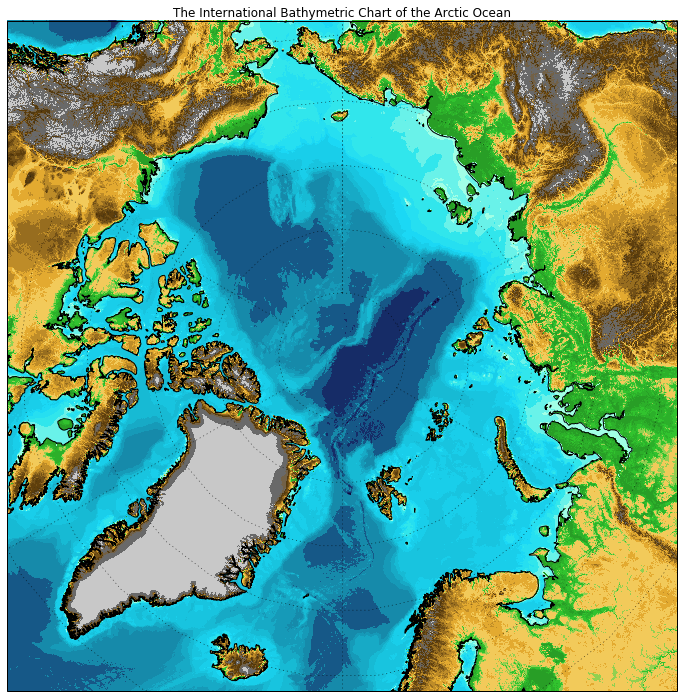

In [3]:
if __name__ == '__main__':
  print ("testing ibcao class")
  import matplotlib.pyplot as plt
  import matplotlib.cm as cm
  import cartopy.crs as ccrs
  from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

  i = IBCAO ()

  f = i.template ()

  plt.show ()